<a href="https://colab.research.google.com/github/Sniper202/Detecccion-de-defectos-en-chips-de-papa/blob/main/CNN/modeloCNNUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms.functional as TF

In [72]:
import os
from os.path import join, exists, isdir, splitext, basename
import numpy as np
import keras.utils as image
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import shutil

In [3]:
class PotatoChips_1:

    def __init__(self, name_title, name_xlabel, startpath, GeneralPath):
        self.name_title = name_title
        self.name_xlabel = name_xlabel
        self.startpath = startpath
        self.GeneralPath = GeneralPath
#         self.name_title2 = name_title2

        # pass

    def print_bold(self, text):
        print('\033[1m{}\033[0m'.format(text))

    def list_files(self):
        for root, dirs, files in os.walk(self.startpath):
            level = root.replace(self.startpath, '').count(os.sep)
            indent = ' '* 4 * (level)

            dir_name = '{}{}/'.format(indent, os.path.basename(root))
            if dir_name.strip().startswith('.'):
                continue

            self.print_bold('\n'+dir_name)

            subindent = ' ' * 4 * (level + 1)
            if level == 0:
                for j in files:
                    if j.startswith('.'):
                        continue
                        print('{}{}'.format(subindent, j))
            else:
                for i, j in enumerate(files):
                    print('{}{}'.format(subindent, j))
                    if i==2:
                        print('{}{}'.format(subindent, '...'))
                        break

    def get_sample_counts(self):
        classes = []
        sample_counts = []

        for j in os.listdir(self.GeneralPath):
            train_class_path = os.path.join(self.GeneralPath, j)
            if os.path.isdir(train_class_path):
                classes.append(j)
                sample_counts.append(len(os.listdir(train_class_path)))
        return classes, sample_counts

    def plot_sample_counts(self, classes, sample_counts):
        plt.rcdefaults()
        fig, ax = plt.subplots(figsize=(7, 5))
        self.name_title
        y_pos = np.arange(len(classes))

        ax.barh(y_pos, sample_counts, align='center', color="green")
        ax.set_yticks(y_pos)
        ax.set_yticklabels(classes)
        ax.invert_yaxis()

        label_offset = max(sample_counts) * 0.001

        for i, count in enumerate(sample_counts):
            ax.text(count + label_offset, i, str(count), va='center', fontsize=8)

        ax.set_title(self.name_title)
        ax.set_xlabel(self.name_xlabel)
        plt.yticks(fontsize=10)
        plt.show()


    def plot_random_samples_class(self,clases,n_muestras,name_title2):
      figura = plt.figure(figsize = (10,5))
      figura.suptitle(name_title2, horizontalalignment = "center", y = 0.95, weight = "bold", fontsize = 13)
      columnas = n_muestras
      filas = len(clases)

      for i, nom_clase in enumerate(clases):
          d_clase = join(self.GeneralPath, nom_clase)
          for j in range(1, n_muestras + 1):
              figura.add_subplot(filas, columnas, i * n_muestras + j)
              plt.axis("off")

              if j == 1:
                  plt.text(0.0, 0.5, nom_clase.replace(" ","\n"), fontsize = 12, wrap = True)
                  continue

              dir_img_random = join(d_clase, random.choice(os.listdir(d_clase)))
              img_random = image.load_img(dir_img_random, target_size =(150,150))
              img_random = (image.img_to_array(img_random))
              img_random /= 255.0
              plt.imshow(img_random)
      plt.show()

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
os.chdir("/content/drive/MyDrive/DATACNN/")

In [6]:
ls

DATA-A/


In [21]:
name_Title = ""
namex_label = "Cantidad de ejemplares"
starpath = 'DATA-A'
Trainpath = 'DATA-A/Train'
# name_Title2 = ""
num_samples = 5
classes_name = ['Defective','Non-Defective']


VP= PotatoChips_1(name_Title,namex_label,starpath,Trainpath)

In [15]:
VP.list_files()


DATA-A/

    Train/

        Non-Defective/
            IMG_20210318_232738.jpg
            IMG_20210318_232804.jpg
            IMG_20210318_232750.jpg
            ...

        Defective/
            IMG_20210319_010511.jpg
            IMG_20210319_010453.jpg
            IMG_20210319_010440.jpg
            ...

    Test/

        Defective/
            IMG_20210319_004702.jpg
            IMG_20210319_004806.jpg
            IMG_20210319_004801.jpg
            ...

        Not Defective/
            IMG_20210318_231155.jpg
            IMG_20210318_231142.jpg
            IMG_20210318_231234.jpg
            ...

    Validation/

        Non-Defective/
            IMG_20210318_232730.jpg
            IMG_20210318_232743.jpg
            IMG_20210318_232808.jpg
            ...

        Defective/
            IMG_20210319_010527.jpg
            IMG_20210319_010521.jpg
            IMG_20210319_010749.jpg
            ...


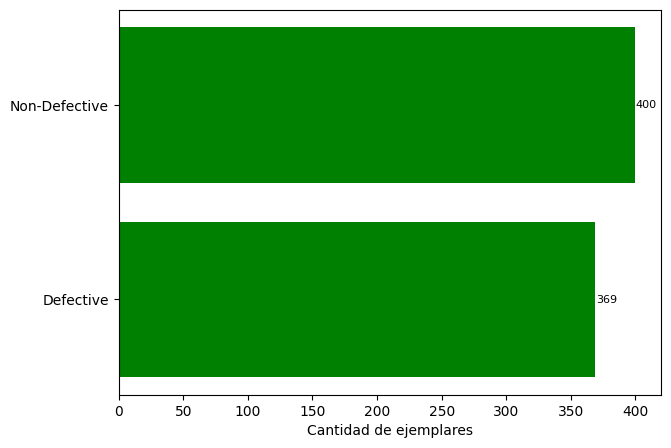

In [9]:
classes, sample_counts= VP.get_sample_counts()
VP.plot_sample_counts(classes, sample_counts)

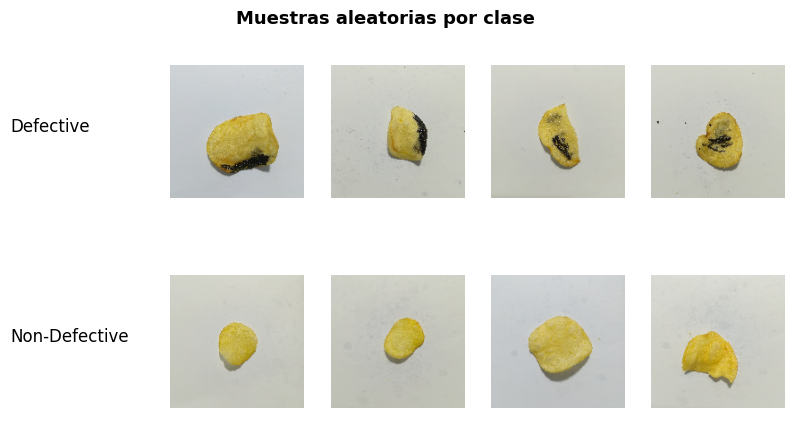

In [9]:
title_2 = 'Muestras aleatorias por clase'
VP.plot_random_samples_class(classes_name,num_samples,title_2)

In [11]:
from genericpath import isdir
import shutil

class PotatoChips_2:
    def __init__(self, name_folder, GeneralPath):
        self.name_folder = name_folder
        self.GeneralPath = GeneralPath

    def create_folder_validation(self, validation_split = 0.2):
        if isdir(self.name_folder):
            print(f'{self.name_folder} Se ha creado el directorio!')
            print('Proceso terminado')
            return
        os.mkdir(self.name_folder)

        for j in os.listdir(self.GeneralPath):
            train_class_path = join(self.GeneralPath, j)
            if isdir(train_class_path):
                validation_class_path = join(self.name_folder,j)
                os.mkdir(validation_class_path)
                files_to_move = int(0.2*len(os.listdir(train_class_path)))

            for i in range(files_to_move):
                random_image = join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
        print('Se ha creado el conjunto de validación con el {:.2%} del dataset de entrenamiento'.format(validation_split))

In [12]:
nameN_folder = "DATA-A/Validation"
VP2 = PotatoChips_2(nameN_folder,Trainpath)

In [13]:
VP2.create_folder_validation()

Se ha creado el conjunto de validación con el 20.00% del dataset de entrenamiento


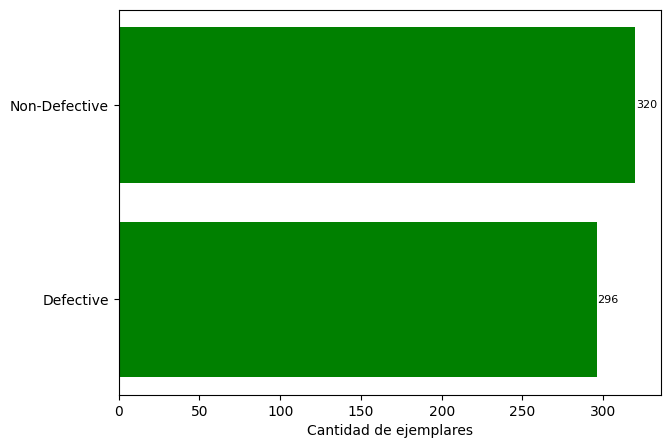

In [22]:
Trainpath_new = 'DATA-A/Train'
name_Title = ""
VP3 = PotatoChips_1(name_Title,namex_label,starpath,Trainpath_new)
classes, sample_counts= VP3.get_sample_counts()
VP3.plot_sample_counts(classes, sample_counts)

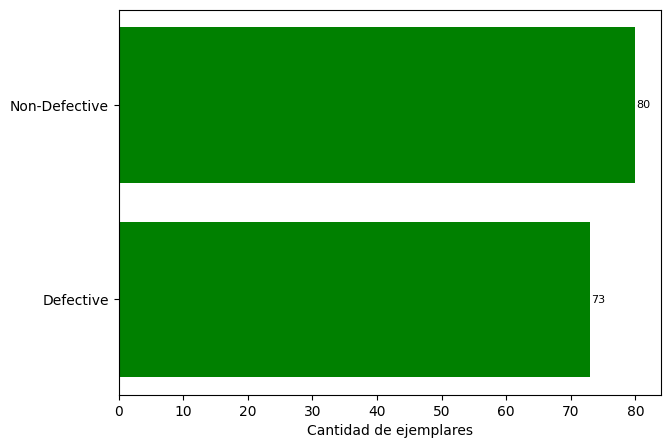

In [24]:
name_Title = ""
Validationpath = 'DATA-A/Validation'
VP4= PotatoChips_1(name_Title,namex_label,starpath,Validationpath)
classes, sample_counts= VP4.get_sample_counts()
VP4.plot_sample_counts(classes, sample_counts)

In [10]:
## UNET

class Conv_3_k(nn.Module):
    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in,channels_out, kernel_size=3,stride=1,padding=1)

    def forward(self, x ):
        return self.conv1(x)

class Double_Conv(nn.Module):

    def __init__(self,channels_in,channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
            Conv_3_k(channels_in,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),

            Conv_3_k(channels_out,channels_out),
            nn.BatchNorm2d(channels_out),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2,2),
            Double_Conv(channels_in,channels_out)
        )
    def forward(self,x):
        return self.encoder(x)


class Up_conv(nn.Module):

    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
            nn.Upsample(scale_factor=2,mode='bicubic'),
            nn.Conv2d(channels_in,channels_in//2,kernel_size=1,stride=1)
        )

        self.decoder = Double_Conv(channels_in,channels_out)

    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)
        x =  torch.cat([x2,x1],dim=1)
        return self.decoder(x)


class UNET_potato_model(nn.Module):


    def __init__(self, channels_in, channels, num_class ):
        super().__init__()
        self.f_conv = Double_Conv(channels_in, channels)
        self.down_conv1 = Down_conv(channels, 2*channels)
        self.down_conv2 = Down_conv(2*channels,4*channels)

        self.middle_conv = Down_conv(4*channels,8*channels)

        self.up_conv1 = Up_conv(8*channels, 4*channels)
        self.up_conv2 = Up_conv(4*channels, 2*channels)
        self.up_conv3 = Up_conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_class, kernel_size=1,stride=1)

    def forward(self, x):
        x1 = self.f_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)

        x4 = self.middle_conv(x3)

        x5 = self.up_conv1(x4,x3)
        x6 = self.up_conv2(x5,x2)
        x7 = self.up_conv3(x6,x1)


        return self.last_conv(x7)

In [11]:
torch.manual_seed(42)
model_UNET = UNET_potato_model(3, 16, 2)

In [12]:
model_UNET

UNET_potato_model(
  (f_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
         

In [19]:
PaTHs = 'MODELO3_29_01_24.pt'
model_UNET.load_state_dict(torch.load(PaTHs, map_location=torch.device('cpu')))
# model_UNET.load_state_dict(torch.load(PaTHs)) # activar esta línea solo si se dispone de GPU
model_UNET.eval()

UNET_potato_model(
  (f_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
         

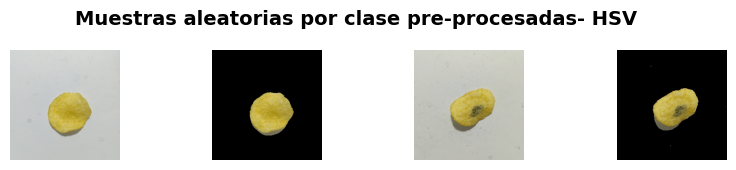

In [61]:
lower_bound= (20, 40, 0)
upper_bound= (150, 255, 255)

fig= plt.figure(figsize=(10, 10))
fig.suptitle('Muestras aleatorias por clase pre-procesadas- HSV', fontsize=14, y=.92, horizontalalignment='center', weight='bold')

for i in range(2):
    sample_class=join('DATA-A/Train',classes[i])
    random_image= join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (256, 256))

    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(img)
    plt.axis('off')

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(result)
    plt.axis('off')

plt.show()

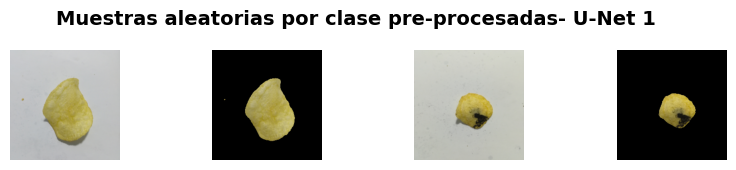

In [66]:
fig= plt.figure(figsize=(10, 10))
fig.suptitle('Muestras aleatorias por clase pre-procesadas- U-Net 1', fontsize=14, y=.92, horizontalalignment='center', weight='bold')
transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
])

for i in range(2):
    sample_class=os.path.join('DATA-A/Train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    imagen = Image.open(random_image).convert('RGB')

    img_transform = transform(imagen).unsqueeze(0)
    with torch.no_grad():
        resultado = model_UNET(img_transform)
    probabilidades = torch.softmax(resultado, dim=1)
    clase_predicha = torch.argmax(probabilidades, dim=1).squeeze().numpy()
    imagen_pil = to_pil_image(img_transform.squeeze())
    mascara_binaria = (clase_predicha).astype(np.uint8)
    imagen_recortada = to_pil_image(to_tensor(imagen_pil) * mascara_binaria)

    fig.add_subplot(6, 4, i*2+1)
    plt.imshow(np.transpose(img_transform.squeeze().numpy(), (1, 2, 0)))
    plt.axis('off')

    fig.add_subplot(6, 4, i*2+2)
    plt.imshow(imagen_recortada)
    plt.axis('off')

plt.show()

In [68]:
def segmentation_semantic_function(img_array):
    imagen = Image.fromarray(np.uint8(img_array))
    img_transform = transform(imagen).unsqueeze(0)
    with torch.no_grad():
        resultado = model_UNET(img_transform)
    probabilidades = torch.softmax(resultado, dim=1)
    clase_predicha = torch.argmax(probabilidades, dim=1).squeeze().numpy()
    imagen_pil = to_pil_image(img_transform.squeeze())
    mascara_binaria = (clase_predicha).astype(np.uint8)
    imagen_recortada = to_pil_image(to_tensor(imagen_pil) * mascara_binaria)
    result= np.array(imagen_recortada).astype('float64')
    return result

In [69]:
from keras.preprocessing.image import ImageDataGenerator

In [70]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40, #Random image rotation
      width_shift_range=0.3, #move images to the sides
      height_shift_range=0.3, #move images up and down
      shear_range=15, #tilt the image
      zoom_range=[0.5,1.5], # Zoom image
      horizontal_flip=True, #random horizontal flip
      vertical_flip= True, #random vertical flip
    preprocessing_function=segmentation_semantic_function,
      fill_mode='nearest')

test_datagen =ImageDataGenerator(rescale=1./255, preprocessing_function=segmentation_semantic_function)

In [74]:
os.rename('DATA-A/Test', 'Test_images')
shutil.move('Test_images', 'DATA-A/Test/Test_images')

'DATA-A/Test/Test_images'

In [75]:
train_generator = train_datagen.flow_from_directory(
  'DATA-A/Train',
  target_size=(256, 256),
  batch_size=16,
  class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'DATA-A/Validation',
        target_size=(256, 256),
        batch_size=16,
        class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(
#         'DATA-A/Test/Test_images',
#         target_size=(224,224),
#         batch_size=1,
#         class_mode='categorical',
#         shuffle=False)

Found 616 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


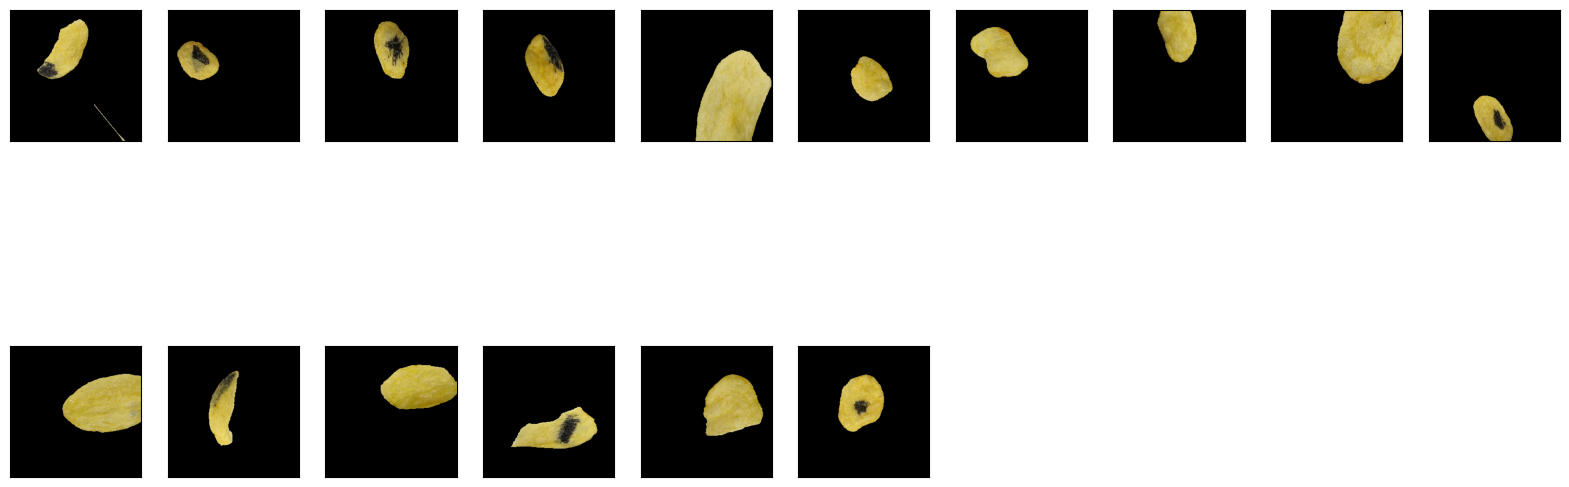

In [ ]:
plt.figure(figsize=(20,8))
for imagen, etiqueta in train_generator:
    for i in range(16):
        plt.subplot(2,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i],cmap='gray')
    plt.show()
    break

In [77]:
import pandas as pd
from prettytable import PrettyTable
label_map = {}
for k, v in train_generator.class_indices.items():
    label_map[v]=k

class_counts= pd.Series(train_generator.classes).value_counts()
C= len(class_counts)
N = len(train_generator.classes)

class_weight= {}
for i, Num_val_class in class_counts.items():
    class_weight[i] = N/(C*Num_val_class)

t = PrettyTable(['class_index', 'class_label', 'class_weight'])
for i in sorted(class_weight.keys()):
    t.add_row([i, label_map[i], '{:.2f}'.format(class_weight[i])])
print(t)

+-------------+---------------+--------------+
| class_index |  class_label  | class_weight |
+-------------+---------------+--------------+
|      0      |   Defective   |     1.04     |
|      1      | Non-Defective |     0.96     |
+-------------+---------------+--------------+


In [ ]:
import keras
from keras import models, layers, callbacks
model = models.Sequential()


model.add(layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))# Convolutional input layer with 32 kernel, 256 x 256 pixel image, 3 channels
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))



model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))


model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

#Dense classification layer
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 62, 62, 64)       

In [ ]:
metric = 'val_accuracy'
best_cb= callbacks.ModelCheckpoint('model_best_principa.h5',
                                         monitor=metric,
                                         verbose=1,
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='max'#,
                                         #save_freq=1
                                  )

opt= keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True)

model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(
                    train_generator,
                    class_weight= class_weight,
                    steps_per_epoch= 38,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps= 10,
                    verbose=1,
                    callbacks= [best_cb])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.5067
Epoch 1: val_accuracy improved from -inf to 0.52288, saving model to model_best_principa.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 214s 6s/step - loss: 0.7477 - accuracy: 0.5067 - val_loss: 0.6927 - val_accuracy: 0.5229
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.4750
Epoch 2: val_accuracy did not improve from 0.52288
38/38 [==============================] - 105s 3s/step - loss: 0.6959 - accuracy: 0.4750 - val_loss: 0.6934 - val_accuracy: 0.4771
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.4933
Epoch 3: val_accuracy improved from 0.52288 to 0.53595, saving model to model_best_principa.h5
38/38 [==============================] - 108s 3s/step - loss: 0.6956 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5359
Epoch 4/100
38/38 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5083
Epoch 4: val_accuracy did not improve from 0.53595
38/38 [==============================] - 108s 3s/step - loss: 0.6930 - accuracy: 0.5083 - val_loss: 0.6937 - val_accuracy: 0.477